In [30]:
from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification
import torch
import seaborn as sns
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchview import draw_graph
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score
from tqdm import tqdm_notebook as tqdm
import time
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
training_path = '../brain-tumor/'

In [5]:
IMAGE_SIZE=(224, 224)
batch_size=32
learning_rate = 1e-4
epochs=15

In [6]:
def images_transforms(phase):
    if phase == 'training':
        data_transformation = transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.RandomRotation(degrees=(-25,20)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    else:
        data_transformation=transforms.Compose([
            transforms.Resize(IMAGE_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    return data_transformation

In [7]:
trainset = datasets.ImageFolder(training_path,transform=images_transforms('training'))
len(trainset)

4479

In [8]:
num_classes = len(trainset.classes)
classes = trainset.classes

In [9]:
classes

['Astrocitoma T1',
 'Astrocitoma T1C+',
 'Astrocitoma T2',
 'Carcinoma T1',
 'Carcinoma T1C+',
 'Carcinoma T2',
 'Ependimoma T1',
 'Ependimoma T1C+',
 'Ependimoma T2',
 'Ganglioglioma T1',
 'Ganglioglioma T1C+',
 'Ganglioglioma T2',
 'Germinoma T1',
 'Germinoma T1C+',
 'Germinoma T2',
 'Glioblastoma T1',
 'Glioblastoma T1C+',
 'Glioblastoma T2',
 'Granuloma T1',
 'Granuloma T1C+',
 'Granuloma T2',
 'Meduloblastoma T1',
 'Meduloblastoma T1C+',
 'Meduloblastoma T2',
 'Meningioma T1',
 'Meningioma T1C+',
 'Meningioma T2',
 'Neurocitoma T1',
 'Neurocitoma T1C+',
 'Neurocitoma T2',
 'Oligodendroglioma T1',
 'Oligodendroglioma T1C+',
 'Oligodendroglioma T2',
 'Papiloma T1',
 'Papiloma T1C+',
 'Papiloma T2',
 'Schwannoma T1',
 'Schwannoma T1C+',
 'Schwannoma T2',
 'Tuberculoma T1',
 'Tuberculoma T1C+',
 'Tuberculoma T2',
 '_NORMAL T1',
 '_NORMAL T2']

In [10]:
trainset, valset = torch.utils.data.random_split(trainset, [3584, 895])
len(trainset), len(valset)

(3584, 895)

In [11]:
train_loader = DataLoader(trainset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(valset,batch_size=batch_size,shuffle=True)

In [12]:
def imshow(img):
    plt.figure(figsize=(20, 20))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

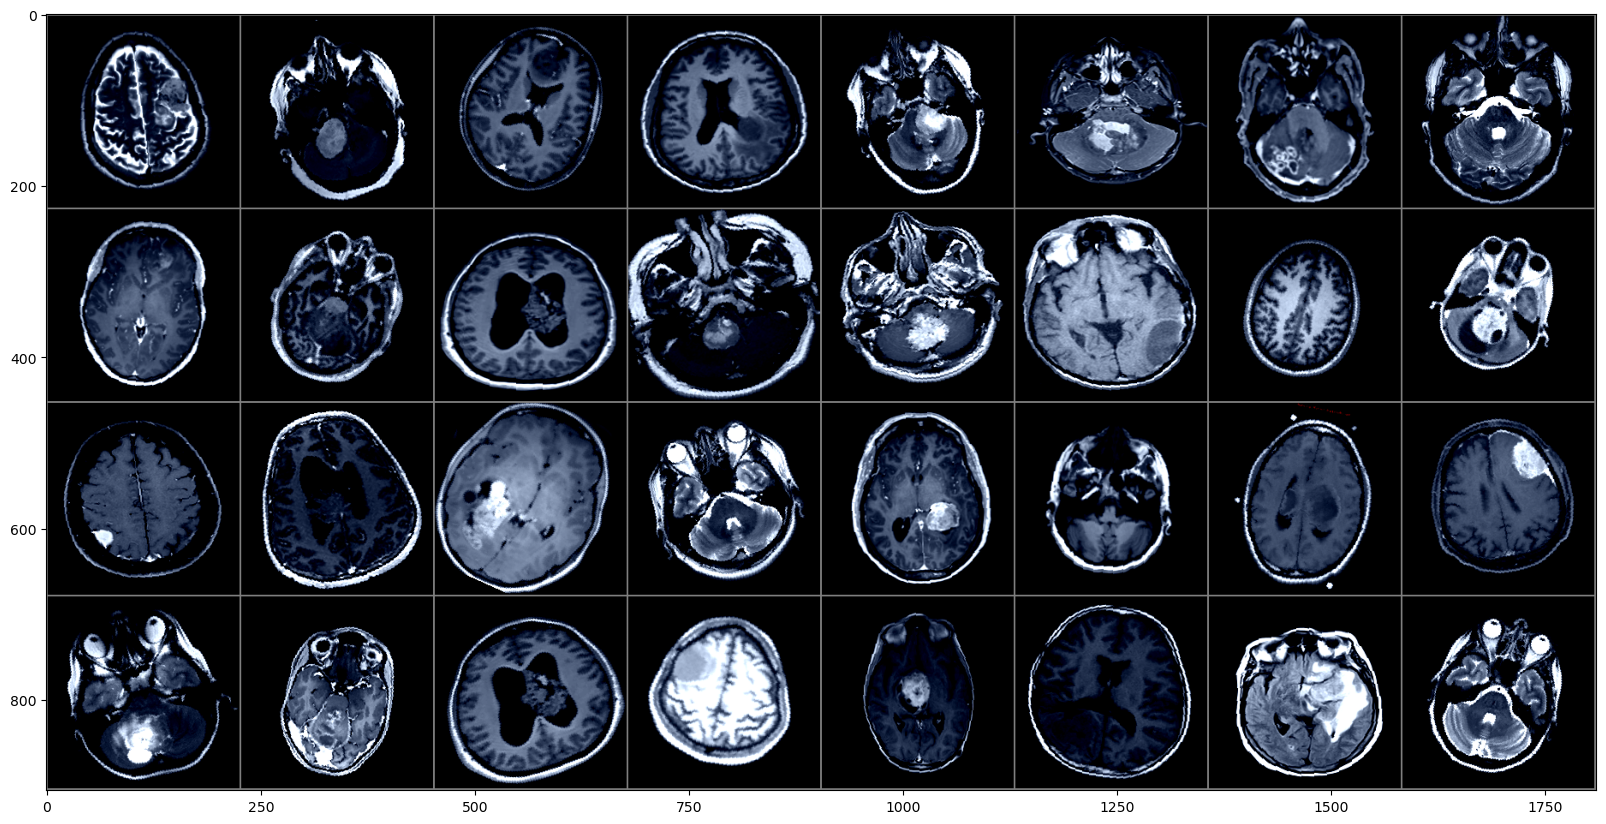

In [13]:
examples = iter(train_loader)
images,labels = next(examples)
imshow(torchvision.utils.make_grid(images))

In [14]:
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224")

In [15]:
model = model.convnext
model = model.to(device)

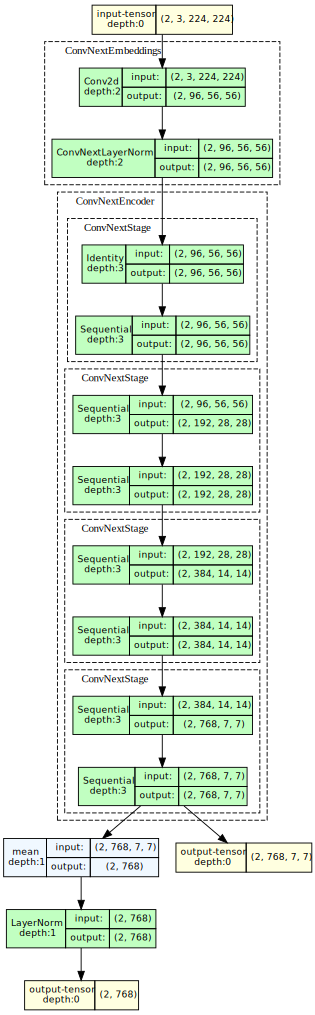

In [16]:
model_graph = draw_graph(model, input_size=(2, 3, 224, 224), device=device, expand_nested=True)
model_graph.visual_graph

In [17]:
sample = torch.rand((2, 3, 224, 224)).to(device)
model(sample)[1].shape

torch.Size([2, 768])

In [18]:
class ConvNextTumorClassifier(nn.Module):
    def __init__(self, base_model, base_model_output_shape, num_classes):
        super().__init__()
        self.base_model = base_model
        self.fc = nn.Sequential(
            nn.Linear(base_model_output_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.base_model(x)[1]
        out = self.fc(x)
        return out

In [19]:
myModel = ConvNextTumorClassifier(model, 768, num_classes)
myModel = myModel.to(device)

criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

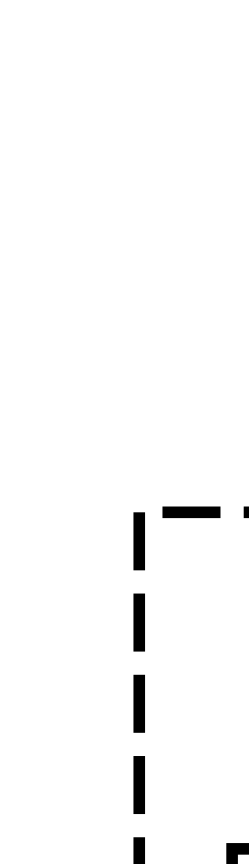

In [20]:
model_graph = draw_graph(myModel, input_size=(1, 3, 224, 224), device=device, expand_nested=True)
model_graph.visual_graph.format = "png"
model_graph.visual_graph.graph_attr.update(dpi='1000')
model_graph.visual_graph.render('model_graph')
model_graph.visual_graph

In [21]:
def train(model,train_loader,criterion,optimizer,val_loader,epochs=25,model_save_path="best_model.pt"):
    train_losses = []
    val_losses = []
    train_auc = []
    val_auc = []
    train_auc_epoch = []
    val_auc_epoch = []
    best_acc = 0.0
    min_loss = np.Inf

    since = time.time()
    y_actual=[]
    y_pred=[]
    for e in range(epochs):
        y_actual=[]
        y_pred=[]
        train_loss = 0.0
        val_loss = 0.0

        # Train the model
        model.train()
        for i, (images, labels) in enumerate(tqdm(train_loader, total=int(len(train_loader)))):
            images = images.to(device).float()
            labels = labels.to(device).long()

            # Forward pass
            outputs = model(images.to(device))
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and accuracy
            train_loss += loss.item()
            
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        train_auc.append(accuracy_score(y_actual, y_pred))

        # Evaluate the model
        model.eval()
        for i, (images, labels) in enumerate(tqdm(val_loader, total=int(len(val_loader)))):
            images = images.to(device).float()
            labels = labels.to(device).long()

            # Forward pass
            outputs = model(images.to(device))
            loss = criterion(outputs, labels)

            # Loss and accuracy
            val_loss += loss.item()
            _,predictes=torch.max(outputs,1)
            y_actual += list(labels.data.cpu().numpy().flatten()) 
            y_pred += list(predictes.detach().cpu().numpy().flatten())
        
        val_auc.append(accuracy_score(y_actual, y_pred))

        # Average losses and accuracies
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        training_auc = train_auc[-1]
        validation_auc = val_auc[-1]
        train_auc_epoch.append(training_auc)
        val_auc_epoch.append(validation_auc)

        # Updating best validation accuracy
        if best_acc < validation_auc:
            best_acc = validation_auc

        # Saving best model
        if min_loss >= val_loss:
            torch.save(model.state_dict(), model_save_path)
            min_loss = val_loss

        print('EPOCH {}/{} Train loss: {:.6f},Validation loss: {:.6f}, Train AUC: {:.4f}  Validation AUC: {:.4f}\n  '.format(e+1, epochs,train_loss,val_loss, training_auc,validation_auc))
        print('-' * 10)
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best validation accuracy: {:4f}'.format(best_acc))
    return train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch

In [22]:
def test(model,testloader,target_labels):
    with torch.no_grad():
        n_correct=0
        n_samples=0
        y_pred=[]
        y_actual=[]
        for i,(images,labels) in enumerate(testloader):
            images=images.to(device)
            labels=labels.to(device)
            
            outputs=model(images)
            
            y_actual+=list(np.array(labels.detach().to('cpu')).flatten())
        # value ,index
            _,predictes=torch.max(outputs,1)
            y_pred+=list(np.array(predictes.detach().to('cpu')).flatten())
        # number of samples in current batch
            n_samples+=labels.shape[0]

            n_correct+= (predictes==labels).sum().item()
            
        y_actual=np.array(y_actual).flatten()
        y_pred=np.array(y_pred).flatten()
        acc = classification_report(y_actual,y_pred,target_names=target_labels)
        accuracy = accuracy_score(y_actual, y_pred)
        print(f"{acc}")
        print(f"Accuracy Score : {accuracy}")

In [23]:
train_losses,val_losses,train_auc ,val_auc,train_auc_epoch,val_auc_epoch=train(myModel,train_loader,criterion,optimizer,val_loader,epochs,model_save_path="tumor_model.pt")

  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 1/15 Train loss: 3.393051,Validation loss: 3.041825, Train AUC: 0.2235  Validation AUC: 0.2447
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 2/15 Train loss: 2.708813,Validation loss: 2.553968, Train AUC: 0.4754  Validation AUC: 0.4892
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 3/15 Train loss: 2.210410,Validation loss: 2.066709, Train AUC: 0.6526  Validation AUC: 0.6589
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 4/15 Train loss: 1.832199,Validation loss: 1.781645, Train AUC: 0.7386  Validation AUC: 0.7386
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 5/15 Train loss: 1.528029,Validation loss: 1.550022, Train AUC: 0.8069  Validation AUC: 0.8046
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 6/15 Train loss: 1.304798,Validation loss: 1.359302, Train AUC: 0.8566  Validation AUC: 0.8522
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 7/15 Train loss: 1.136531,Validation loss: 1.206490, Train AUC: 0.8962  Validation AUC: 0.8906
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 8/15 Train loss: 0.987816,Validation loss: 1.100474, Train AUC: 0.9269  Validation AUC: 0.9174
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 9/15 Train loss: 0.855054,Validation loss: 0.979167, Train AUC: 0.9512  Validation AUC: 0.9435
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 10/15 Train loss: 0.747718,Validation loss: 0.961222, Train AUC: 0.9668  Validation AUC: 0.9522
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 11/15 Train loss: 0.694504,Validation loss: 0.853339, Train AUC: 0.9701  Validation AUC: 0.9609
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 12/15 Train loss: 0.597334,Validation loss: 0.803910, Train AUC: 0.9827  Validation AUC: 0.9714
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 13/15 Train loss: 0.539257,Validation loss: 0.740172, Train AUC: 0.9883  Validation AUC: 0.9781
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 14/15 Train loss: 0.480188,Validation loss: 0.667048, Train AUC: 0.9925  Validation AUC: 0.9830
  
----------


  0%|          | 0/112 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

EPOCH 15/15 Train loss: 0.439183,Validation loss: 0.617194, Train AUC: 0.9939  Validation AUC: 0.9857
  
----------
Training completed in 18m 42s
Best validation accuracy: 0.985711


In [24]:
test(myModel, train_loader, target_labels=classes)

                        precision    recall  f1-score   support

        Astrocitoma T1       1.00      1.00      1.00       137
      Astrocitoma T1C+       1.00      1.00      1.00       197
        Astrocitoma T2       1.00      1.00      1.00       132
          Carcinoma T1       1.00      1.00      1.00        55
        Carcinoma T1C+       1.00      1.00      1.00        87
          Carcinoma T2       1.00      1.00      1.00        55
         Ependimoma T1       1.00      1.00      1.00        37
       Ependimoma T1C+       1.00      1.00      1.00        40
         Ependimoma T2       1.00      1.00      1.00        47
      Ganglioglioma T1       1.00      1.00      1.00        11
    Ganglioglioma T1C+       1.00      1.00      1.00        13
      Ganglioglioma T2       1.00      0.82      0.90        17
          Germinoma T1       1.00      1.00      1.00        22
        Germinoma T1C+       1.00      1.00      1.00        29
          Germinoma T2       0.93      

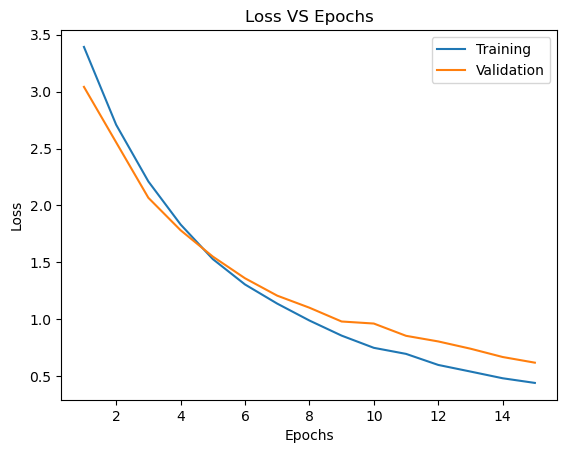

In [26]:
plt.plot(range(1, epochs+1), train_losses, label="Training")
plt.plot(range(1, epochs+1), val_losses, label="Validation")
plt.title("Loss VS Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

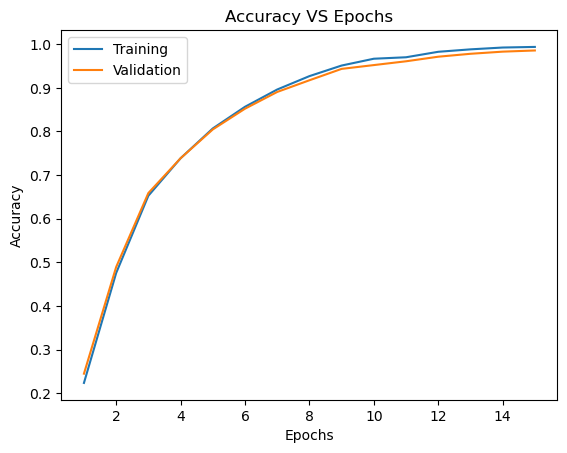

In [27]:
plt.plot(range(1, epochs+1), train_auc, label="Training")
plt.plot(range(1, epochs+1), val_auc, label="Validation")
plt.title("Accuracy VS Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [28]:
from sklearn.metrics import confusion_matrix
import numpy as np

def test(model, data_loader, target_labels):
    model.eval()
    y_true = []
    y_pred = []

    for inputs, targets in data_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plot_confusion_matrix(conf_matrix, target_labels)

def plot_confusion_matrix(cm, target_labels):
    plt.figure(figsize=(20, 12))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=target_labels, yticklabels=target_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


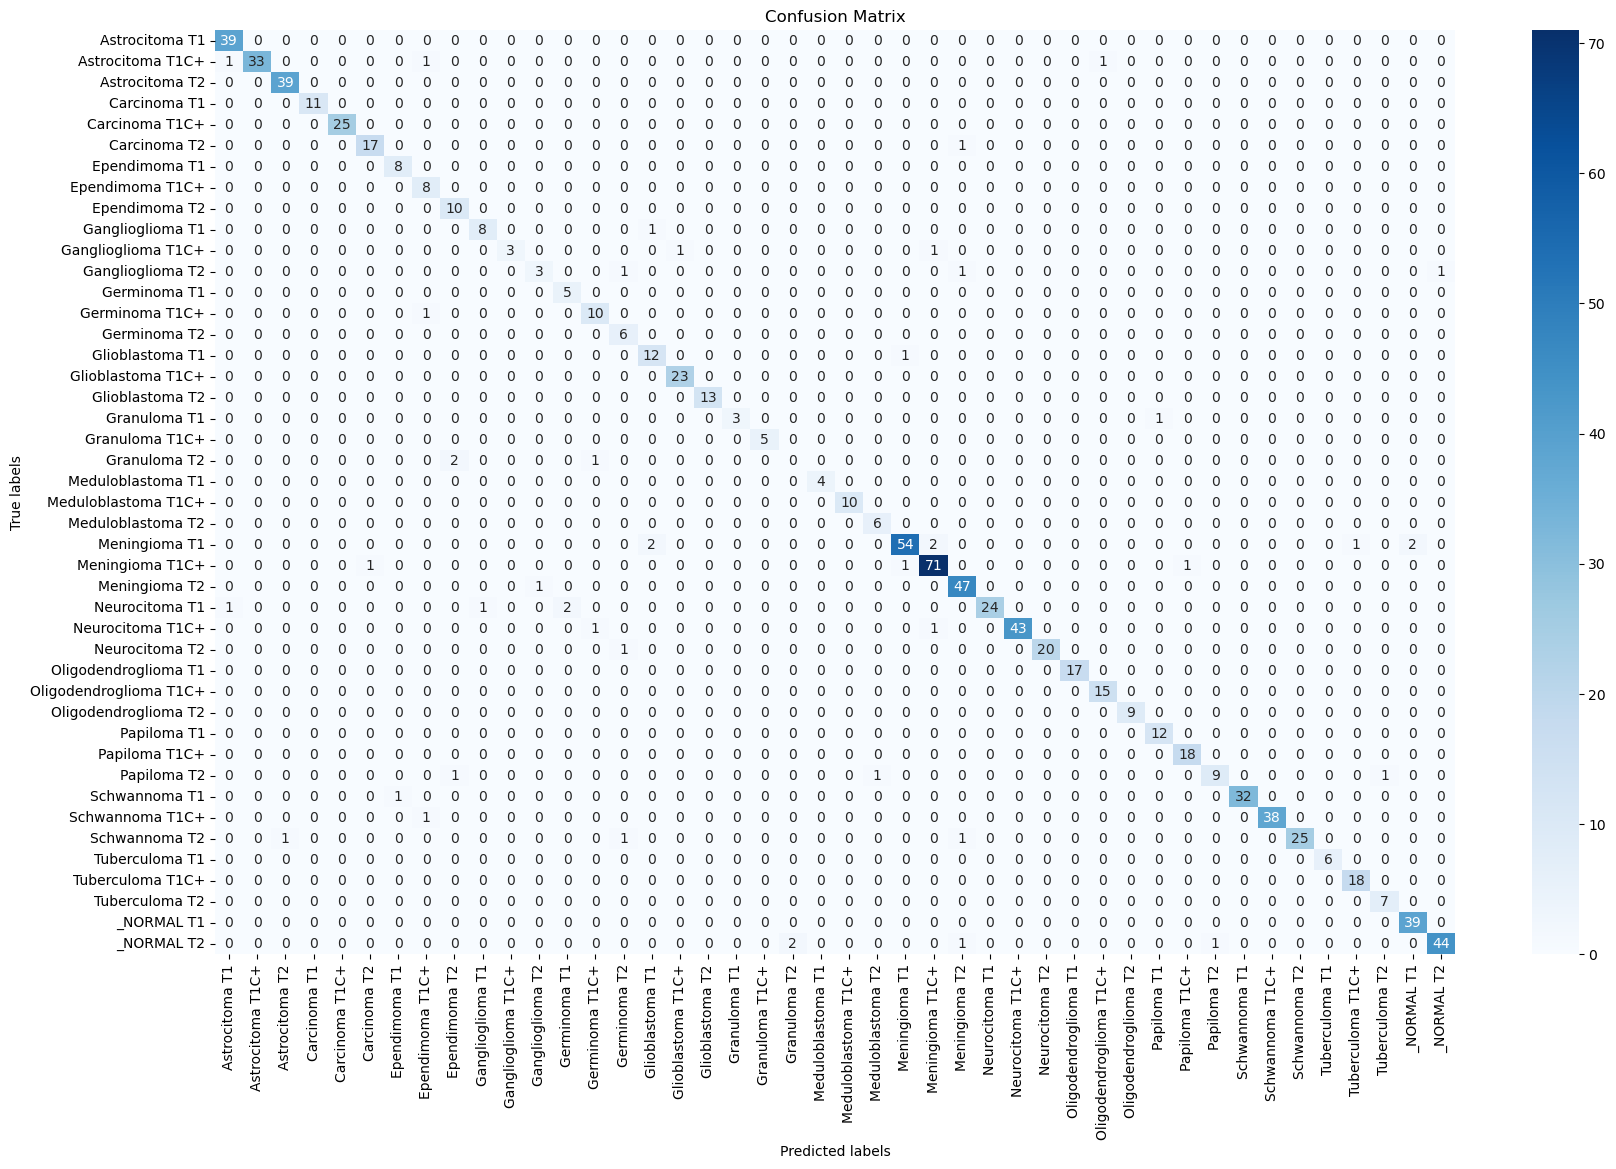

In [31]:
test(myModel, val_loader, target_labels=classes)
